In [287]:
import plaidml.keras
plaidml.keras.install_backend()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

import math

# import pyflux as pf

import warnings
warnings.filterwarnings(action='once')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
#from keras.layers import Concatenate
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pickle

from numpy.random import seed

from tensorflow import set_random_seed

In [186]:
seed(2019)
set_random_seed(2019)

## Importing Data

In [187]:
df_combined = pd.read_pickle('./processed_data/df_combined.pickle')

In [188]:
df_combined.head(2)

,ds,y,vix,gold
0,2017-02-08 00:00:00,1054.03,18.879,2732.0
1,2017-02-08 01:00:00,1060.48,18.915,2693.0


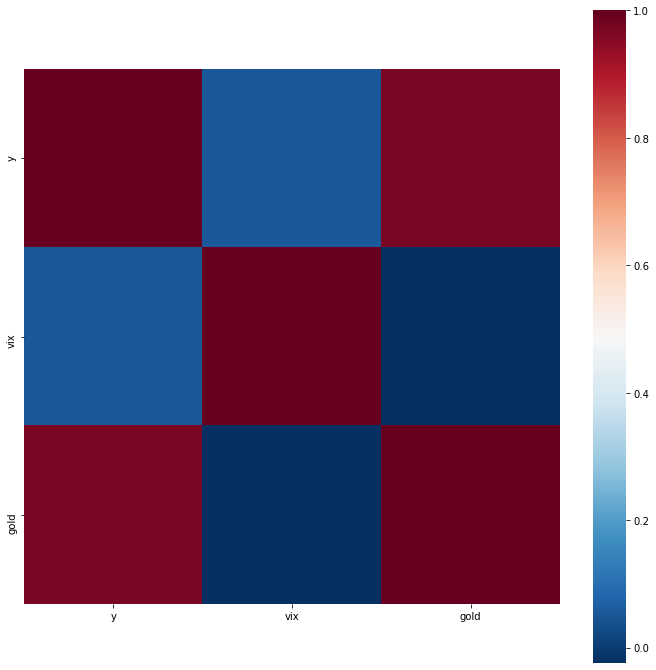

In [263]:
correlations = df_combined.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(correlations, square=True, cmap="RdBu_r");

## Functions

In [189]:
def split_train_test_chronological(df, ratio = 0.9, use_ratio = True, index = 1000):
    
    '''
    Input is a dataframe, and a ratio. Splits dataframe into 2 dataframes chronologically.
    Returns first dataframe up to the index of the length of the input dataframe times the input ratio, 
    and returns second dataframe of remaining elements.
    use_ratio is a flag, wether ratio should be used or indicies instead.
    
    df = input dataframe
    ratio = ratio to be used for splitting
    use_ratio = if True, use ratio, 
    index = index to split input dataframe on
    
    '''
    if use_ratio:
        size = len(df) * ratio
        size_round = round(size)

        df_train = df[0:(size_round)]
        df_test = df[size_round:]
    else:
        df_train = df[0:(index)]
        df_test = df[index:]
    return df_train, df_test

In [191]:
def make_variables(df, lags, look_back, predict_window):
    
    '''
    In order to use keras LSTM, we need to convert the input into a keras-friendly input.
    
    df = input dataframe
    lags = number of lags
    look_back = number of preceding elements to be considered
    predict_window = size of window for predictions
    
    '''
    
    features = lags + 1
    start = look_back
    stop = len(df) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = df[i - j : i - j + lags + 1, -1]
            lstm_in_X[i - start, index] = np.ravel(X)
            Y = df[i - j + lags + 1, -1]
            lstm_in_Y[i-start, index] = Y
            
    return lstm_in_X, lstm_in_Y, features

In [192]:
def train_lstm(train_X, train_Y, lags, look_back, predict_window, lstm_nodes,
               dense_layers, dropout = 0.1, loss_type = 'hinge', optimizer_type = 'adam',
               number_epochs = 300, batch_size = 24, ):
    
    
    model = Sequential()
    model.add(LSTM(lstm_nodes, input_shape=(look_back+1, features)))
    model.add(Dropout(dropout))
    for nodes in dense_layers:
        model.add(Dense(nodes))
        model.add(Dropout(dropout))
    model.add(Dense(look_back + 1))
    model.compile(loss=loss_type, optimizer= optimizer_type)
    model.fit(train_X, train_Y, epochs=number_epochs, batch_size = batch_size, verbose = 1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [ ]:
def make_rolling_window(model, train_x, train_y, test_x, test_y, batch_size = 32, epochs = 2):
    predictions_test = []
    actuals_test = []
    
    for i in range(0, len(test_y) - 1):
        model.fit(train_x, train_y, 
                    epochs= epochs, 
                    batch_size = batch_size, 
                    validation_data=(test_x[i].reshape(1,1,23), (test_y[i].reshape(1 ,))),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)
        pred_Y_test = model.predict(test_x)
        train_x = np.concatenate((train_x, (test_x[i].reshape(1 , 1 , 23))))

        train_y = np.concatenate((train_y, (test_y[i].reshape(1 ,))))
        predict_test = pred_Y_test[-1,-1]
        actual_test = train_y[-1]
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        
    
    return predictions_test, actuals_test

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    
    
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Train, Val, Test split

In [196]:
df_train, df_test = split_train_test_chronological(df_combined, ratio = .99)

In [197]:
df_train, df_val = split_train_test_chronological(df_combined, ratio = .95)

## Modeling

In [247]:
# load dataset
values = df_combined.drop('ds', axis = 1).values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)

reframed_2 = series_to_supervised(values, 7, 1)
reframed_2.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
7,1054.030029,18.879000,2732.000000,1060.479980,18.915001,2693.000000,1062.939941,18.860001,2712.120117,1065.819946,...,2742.100098,1066.310059,18.878000,2735.270020,1066.060059,18.886999,2732.120117,1066.260010,18.886999,2731.959961
8,1060.479980,18.915001,2693.000000,1062.939941,18.860001,2712.120117,1065.819946,18.770000,2743.989990,1068.150024,...,2735.270020,1066.060059,18.886999,2732.120117,1066.260010,18.886999,2731.959961,1033.900024,18.886999,2710.209961
9,1062.939941,18.860001,2712.120117,1065.819946,18.770000,2743.989990,1068.150024,18.770000,2742.100098,1066.310059,...,2732.120117,1066.260010,18.886999,2731.959961,1033.900024,18.886999,2710.209961,1032.180054,18.886999,2719.310059
10,1065.819946,18.770000,2743.989990,1068.150024,18.770000,2742.100098,1066.310059,18.878000,2735.270020,1066.060059,...,2731.959961,1033.900024,18.886999,2710.209961,1032.180054,18.886999,2719.310059,1037.780029,18.886999,2732.989990
11,1068.150024,18.770000,2742.100098,1066.310059,18.878000,2735.270020,1066.060059,18.886999,2732.120117,1066.260010,...,2710.209961,1032.180054,18.886999,2719.310059,1037.780029,18.886999,2732.989990,1045.300049,18.886999,2719.979980


In [249]:
# drop columns we don't want to predict
y = reframed.iloc[:,-12].values
X = reframed.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]

test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 23) (12000,) (341, 1, 23) (341,) (320, 1, 23) (320,)


In [250]:
y

array([0.00600698, 0.00590796, 0.00589451, ..., 0.40667784, 0.4065094 ,
       0.40857488], dtype=float32)

In [276]:
# drop columns we don't want to predict
y = reframed_2.iloc[:,-12].values
X = reframed_2.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]

test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 23) (12000,) (341, 1, 23) (341,) (320, 1, 23) (320,)


In [277]:
y                          

array([1068.15, 1066.31, 1066.06, ..., 8513.3 , 8510.17, 8548.55],
      dtype=float32)

In [280]:
LSTM_model_2 = Sequential()
LSTM_model_2.add(LSTM(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.20,recurrent_dropout=0.20))
LSTM_model_2.add(Dense(64))
# LSTM_model_2.add(LSTM(16, activation='relu'))
LSTM_model_2.add(Dense(1))
LSTM_model_2.compile(optimizer='adam', loss='mse')




In [281]:
history_2 = LSTM_model_2.fit(train_X, train_y, 
                    epochs= 200, 
                    batch_size = 32, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 341 samples
Epoch 1/200
 - 8s - loss: 1155521.1083 - val_loss: 510859.1422
Epoch 2/200
 - 2s - loss: 552400.2267 - val_loss: 499067.5001
Epoch 3/200
 - 2s - loss: 393317.6611 - val_loss: 566411.4622
Epoch 4/200
 - 2s - loss: 354509.8768 - val_loss: 526273.4775
Epoch 5/200
 - 2s - loss: 262476.7765 - val_loss: 607219.6069
Epoch 6/200
 - 2s - loss: 235657.7090 - val_loss: 591851.1710
Epoch 7/200
 - 2s - loss: 214402.2766 - val_loss: 642345.9998
Epoch 8/200
 - 2s - loss: 192961.7354 - val_loss: 585742.9106
Epoch 9/200
 - 2s - loss: 167234.7339 - val_loss: 598396.1626
Epoch 10/200
 - 2s - loss: 142929.1472 - val_loss: 605608.8706
Epoch 11/200
 - 2s - loss: 126166.7817 - val_loss: 609330.8468
Epoch 12/200
 - 2s - loss: 124570.9578 - val_loss: 636181.8488
Epoch 13/200
 - 2s - loss: 104540.1089 - val_loss: 622463.0581
Epoch 14/200
 - 2s - loss: 118909.8614 - val_loss: 602211.8785
Epoch 15/200
 - 2s - loss: 89234.3142 - val_loss: 613371.6404
Epoch 16/200
 - 

Epoch 132/200
 - 2s - loss: 10401.4476 - val_loss: 616130.1937
Epoch 133/200
 - 2s - loss: 11550.8372 - val_loss: 602026.1813
Epoch 134/200
 - 2s - loss: 9455.2049 - val_loss: 613259.9765
Epoch 135/200
 - 2s - loss: 17475.4735 - val_loss: 600711.1481
Epoch 136/200
 - 2s - loss: 10587.5354 - val_loss: 616772.9820
Epoch 137/200
 - 2s - loss: 8955.7734 - val_loss: 611937.0231
Epoch 138/200
 - 2s - loss: 10608.2661 - val_loss: 597525.3369
Epoch 139/200
 - 2s - loss: 11371.1344 - val_loss: 606406.6026
Epoch 140/200
 - 2s - loss: 9615.3815 - val_loss: 595373.8382
Epoch 141/200
 - 2s - loss: 10079.1981 - val_loss: 614805.8499
Epoch 142/200
 - 2s - loss: 9800.4246 - val_loss: 607451.3283
Epoch 143/200
 - 2s - loss: 10909.4729 - val_loss: 605746.9467
Epoch 144/200
 - 2s - loss: 10554.4870 - val_loss: 602591.2390
Epoch 145/200
 - 2s - loss: 9944.4172 - val_loss: 606344.9470
Epoch 146/200
 - 2s - loss: 10700.5158 - val_loss: 622790.0209
Epoch 147/200
 - 2s - loss: 12288.6308 - val_loss: 604881.35

In [282]:
res_2 = make_rolling_window(LSTM_model_2, train_X, train_y, val_X, val_y, batch_size = 128)

Train on 12000 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 9486.7992 - val_loss: 566046.4375
Epoch 2/2
 - 1s - loss: 10180.3848 - val_loss: 551187.0000
Train on 12001 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 6436.2544 - val_loss: 576307.0625
Epoch 2/2
 - 1s - loss: 6924.9651 - val_loss: 574620.6250
Train on 12002 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7054.1497 - val_loss: 579432.4375
Epoch 2/2
 - 1s - loss: 7309.6793 - val_loss: 588328.6875
Train on 12003 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8139.2625 - val_loss: 604909.8750
Epoch 2/2
 - 1s - loss: 10030.5209 - val_loss: 605064.8125
Train on 12004 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 10616.3699 - val_loss: 592430.1250
Epoch 2/2
 - 1s - loss: 8775.1244 - val_loss: 612942.9375
Train on 12005 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7226.9026 - val_loss: 694522.4375
Epoch 2/2
 - 1s - loss: 12435.9439 - val_loss: 687045.1250
Train on 12006 samples, 

Epoch 2/2
 - 2s - loss: 15111.8315 - val_loss: 627341.7500
Train on 12051 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 5691.2105 - val_loss: 667759.5000
Epoch 2/2
 - 2s - loss: 9801.7381 - val_loss: 657505.1875
Train on 12052 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8237.1120 - val_loss: 688776.3750
Epoch 2/2
 - 2s - loss: 7951.0529 - val_loss: 681097.1875
Train on 12053 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 6789.2671 - val_loss: 689422.5000
Epoch 2/2
 - 2s - loss: 8549.1835 - val_loss: 697618.5000
Train on 12054 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7438.2145 - val_loss: 698974.0000
Epoch 2/2
 - 2s - loss: 7133.4240 - val_loss: 695915.6250
Train on 12055 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7981.1816 - val_loss: 645723.3125
Epoch 2/2
 - 2s - loss: 5468.8570 - val_loss: 651088.6250
Train on 12056 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7641.6511 - val_loss: 651209.6250
Epoch 2/2
 - 2s - loss: 894

 - 4s - loss: 7635.8968 - val_loss: 682100.5625
Epoch 2/2
 - 2s - loss: 6846.5229 - val_loss: 696490.5000
Train on 12102 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7133.1516 - val_loss: 657721.8125
Epoch 2/2
 - 2s - loss: 7086.9949 - val_loss: 659666.7500
Train on 12103 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7917.9898 - val_loss: 607225.2500
Epoch 2/2
 - 2s - loss: 9926.7962 - val_loss: 606894.2500
Train on 12104 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 5883.3696 - val_loss: 648719.7500
Epoch 2/2
 - 2s - loss: 6614.4498 - val_loss: 644444.0000
Train on 12105 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 5985.0278 - val_loss: 645921.4375
Epoch 2/2
 - 2s - loss: 7910.4140 - val_loss: 639333.0000
Train on 12106 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 6644.3145 - val_loss: 672472.8750
Epoch 2/2
 - 1s - loss: 6870.8860 - val_loss: 665759.1875
Train on 12107 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8842.8895 - va

Train on 12152 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 5489.1685 - val_loss: 613240.4375
Epoch 2/2
 - 2s - loss: 6511.4156 - val_loss: 613623.2500
Train on 12153 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5579.0499 - val_loss: 557590.0000
Epoch 2/2
 - 2s - loss: 7091.3499 - val_loss: 564389.3750
Train on 12154 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7383.4437 - val_loss: 571074.3125
Epoch 2/2
 - 2s - loss: 8934.8502 - val_loss: 569069.5000
Train on 12155 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 8273.5357 - val_loss: 580305.0625
Epoch 2/2
 - 2s - loss: 13251.7052 - val_loss: 595175.3125
Train on 12156 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 11324.5357 - val_loss: 626014.0000
Epoch 2/2
 - 2s - loss: 7510.0611 - val_loss: 623585.1250
Train on 12157 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7158.7921 - val_loss: 617258.8125
Epoch 2/2
 - 2s - loss: 5821.8291 - val_loss: 610728.5000
Train on 12158 samples, va

Epoch 2/2
 - 2s - loss: 9398.9430 - val_loss: 646084.3125
Train on 12203 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6788.1089 - val_loss: 521146.8750
Epoch 2/2
 - 2s - loss: 6076.8468 - val_loss: 521345.3438
Train on 12204 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6898.9224 - val_loss: 522103.2812
Epoch 2/2
 - 2s - loss: 5228.8071 - val_loss: 518235.1250
Train on 12205 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5789.1044 - val_loss: 533432.6875
Epoch 2/2
 - 2s - loss: 5391.2725 - val_loss: 528450.5625
Train on 12206 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7740.5854 - val_loss: 525937.6250
Epoch 2/2
 - 2s - loss: 6046.5261 - val_loss: 541462.0625
Train on 12207 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6928.4911 - val_loss: 534088.3125
Epoch 2/2
 - 2s - loss: 6271.2040 - val_loss: 530088.5000
Train on 12208 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 10374.5687 - val_loss: 560656.5625
Epoch 2/2
 - 2s - loss: 101

 - 2s - loss: 9298.2570 - val_loss: 672841.6875
Epoch 2/2
 - 2s - loss: 6650.3393 - val_loss: 673052.0000
Train on 12254 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6871.4476 - val_loss: 699216.5000
Epoch 2/2
 - 2s - loss: 8678.7945 - val_loss: 716709.8125
Train on 12255 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7246.5454 - val_loss: 614520.5000
Epoch 2/2
 - 2s - loss: 6899.0483 - val_loss: 615091.3125
Train on 12256 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 10821.4056 - val_loss: 545077.5625
Epoch 2/2
 - 2s - loss: 5997.8023 - val_loss: 545911.3750
Train on 12257 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 8206.7573 - val_loss: 567157.5625
Epoch 2/2
 - 2s - loss: 7426.6725 - val_loss: 565935.5000
Train on 12258 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4975.6751 - val_loss: 598164.0000
Epoch 2/2
 - 2s - loss: 6154.1367 - val_loss: 586938.9375
Train on 12259 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 14787.7208 - 

Train on 12304 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4215.2825 - val_loss: 574175.4375
Epoch 2/2
 - 2s - loss: 5718.9294 - val_loss: 573085.6250
Train on 12305 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6381.9964 - val_loss: 569945.3750
Epoch 2/2
 - 2s - loss: 6062.7259 - val_loss: 570043.4375
Train on 12306 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 8796.4885 - val_loss: 552033.7500
Epoch 2/2
 - 2s - loss: 11323.5679 - val_loss: 552616.5625
Train on 12307 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7759.5803 - val_loss: 575070.8125
Epoch 2/2
 - 2s - loss: 7073.3476 - val_loss: 566172.1250
Train on 12308 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5761.3202 - val_loss: 571140.7500
Epoch 2/2
 - 2s - loss: 4836.8582 - val_loss: 566584.4375
Train on 12309 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6983.6027 - val_loss: 563120.8750
Epoch 2/2
 - 2s - loss: 5336.9751 - val_loss: 564298.8125
Train on 12310 samples, val

In [283]:
LSTM_model_3 = Sequential()
LSTM_model_3.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.20,recurrent_dropout=0.20))
LSTM_model_3.add(Dense(32))
# LSTM_model_3.add(LSTM(16, activation='relu'))
LSTM_model_3.add(Dense(1))
LSTM_model_3.compile(optimizer='adam', loss='mse')





In [284]:
history_3 = LSTM_model_3.fit(train_X, train_y, 
                    epochs= 200, 
                    batch_size = 32, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 341 samples
Epoch 1/200
 - 10s - loss: 1502832.4637 - val_loss: 207035.2041
Epoch 2/200
 - 5s - loss: 832724.0346 - val_loss: 395961.5041
Epoch 3/200
 - 5s - loss: 634450.5901 - val_loss: 485697.0751
Epoch 4/200
 - 5s - loss: 595665.4696 - val_loss: 333706.7309
Epoch 5/200
 - 5s - loss: 545648.6228 - val_loss: 475599.9688
Epoch 6/200
 - 5s - loss: 465224.5832 - val_loss: 514627.8890
Epoch 7/200
 - 5s - loss: 353140.1324 - val_loss: 524312.6702
Epoch 8/200
 - 5s - loss: 297420.5733 - val_loss: 528573.6164
Epoch 9/200
 - 5s - loss: 227346.6146 - val_loss: 588274.5471
Epoch 10/200
 - 5s - loss: 199497.2403 - val_loss: 592290.0527
Epoch 11/200
 - 5s - loss: 183979.7126 - val_loss: 581165.4515
Epoch 12/200
 - 5s - loss: 173360.6006 - val_loss: 597060.8239
Epoch 13/200
 - 5s - loss: 128790.2654 - val_loss: 635450.1765
Epoch 14/200
 - 5s - loss: 134742.0503 - val_loss: 583985.6070
Epoch 15/200
 - 5s - loss: 134481.9852 - val_loss: 549157.5228
Epoch 16/200
 

Epoch 132/200
 - 5s - loss: 12678.1495 - val_loss: 587833.8605
Epoch 133/200
 - 5s - loss: 19304.8917 - val_loss: 598249.1464
Epoch 134/200
 - 5s - loss: 21741.2229 - val_loss: 592944.5673
Epoch 135/200
 - 5s - loss: 38325.1022 - val_loss: 438105.0641
Epoch 136/200
 - 4s - loss: 71386.6170 - val_loss: 511312.9062
Epoch 137/200
 - 5s - loss: 62133.7817 - val_loss: 521976.8347
Epoch 138/200
 - 5s - loss: 51305.6448 - val_loss: 528719.8525
Epoch 139/200
 - 5s - loss: 52565.9730 - val_loss: 527466.2823
Epoch 140/200
 - 4s - loss: 50529.1371 - val_loss: 516719.1169
Epoch 141/200
 - 4s - loss: 48297.9000 - val_loss: 516779.3955
Epoch 142/200
 - 5s - loss: 41818.4026 - val_loss: 498540.1343
Epoch 143/200
 - 4s - loss: 43843.2173 - val_loss: 494042.3712
Epoch 144/200
 - 5s - loss: 45461.5500 - val_loss: 567680.6246
Epoch 145/200
 - 5s - loss: 41672.6622 - val_loss: 562004.4992
Epoch 146/200
 - 4s - loss: 39201.9569 - val_loss: 587623.9897
Epoch 147/200
 - 5s - loss: 38617.4281 - val_loss: 5743

In [286]:
res_3 = make_rolling_window(LSTM_model_3, train_X, train_y, val_X, val_y)

Train on 12000 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 10789.0059 - val_loss: 541837.2500
Epoch 2/2
 - 1s - loss: 10954.4502 - val_loss: 545002.2500
Train on 12001 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 15788.2712 - val_loss: 579280.4375
Epoch 2/2
 - 2s - loss: 11987.3138 - val_loss: 571716.5000
Train on 12002 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 10390.5439 - val_loss: 564467.5625
Epoch 2/2
 - 1s - loss: 9401.8322 - val_loss: 564954.0625
Train on 12003 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 14435.5771 - val_loss: 593377.1875
Epoch 2/2
 - 1s - loss: 9868.2343 - val_loss: 593680.8125
Train on 12004 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 13585.9284 - val_loss: 588420.8125
Epoch 2/2
 - 1s - loss: 11242.9788 - val_loss: 594861.1875
Train on 12005 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 10800.0311 - val_loss: 673894.3125
Epoch 2/2
 - 1s - loss: 10197.9621 - val_loss: 664575.6250
Train on 12006 sam

 - 3s - loss: 9111.8746 - val_loss: 630968.4375
Epoch 2/2
 - 1s - loss: 11736.9813 - val_loss: 636676.5625
Train on 12051 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 8710.9459 - val_loss: 664951.4375
Epoch 2/2
 - 1s - loss: 12698.3957 - val_loss: 669682.1250
Train on 12052 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 11809.9919 - val_loss: 669609.7500
Epoch 2/2
 - 1s - loss: 9089.4839 - val_loss: 676263.6875
Train on 12053 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 9455.5457 - val_loss: 688962.0000
Epoch 2/2
 - 1s - loss: 12587.7597 - val_loss: 694060.2500
Train on 12054 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 11262.3426 - val_loss: 686432.5000
Epoch 2/2
 - 1s - loss: 10340.1885 - val_loss: 690035.6250
Train on 12055 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 6602.5993 - val_loss: 656956.5625
Epoch 2/2
 - 2s - loss: 6852.7446 - val_loss: 640169.9375
Train on 12056 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8526.228

Train on 12101 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8430.0901 - val_loss: 677721.6875
Epoch 2/2
 - 2s - loss: 7095.6211 - val_loss: 673794.0625
Train on 12102 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8041.3129 - val_loss: 642150.2500
Epoch 2/2
 - 2s - loss: 6700.0873 - val_loss: 645618.5000
Train on 12103 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 7242.7750 - val_loss: 615029.3125
Epoch 2/2
 - 2s - loss: 6028.8861 - val_loss: 616543.5625
Train on 12104 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 12561.0850 - val_loss: 645221.1250
Epoch 2/2
 - 2s - loss: 7844.3285 - val_loss: 649826.5000
Train on 12105 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8794.7828 - val_loss: 641165.7500
Epoch 2/2
 - 2s - loss: 9782.4228 - val_loss: 633442.2500
Train on 12106 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 8140.8721 - val_loss: 663191.1250
Epoch 2/2
 - 2s - loss: 6990.9125 - val_loss: 664588.0000
Train on 12107 samples, val

Epoch 2/2
 - 2s - loss: 5921.4742 - val_loss: 565104.1875
Train on 12152 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5476.1093 - val_loss: 590241.4375
Epoch 2/2
 - 2s - loss: 5587.0652 - val_loss: 587082.1875
Train on 12153 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4829.7184 - val_loss: 558927.0625
Epoch 2/2
 - 2s - loss: 6760.3337 - val_loss: 555982.8750
Train on 12154 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6025.3549 - val_loss: 572513.5625
Epoch 2/2
 - 2s - loss: 4849.7966 - val_loss: 569725.3125
Train on 12155 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7582.5732 - val_loss: 582896.4375
Epoch 2/2
 - 2s - loss: 5642.4315 - val_loss: 576918.5000
Train on 12156 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5170.9082 - val_loss: 599151.5625
Epoch 2/2
 - 2s - loss: 4565.7571 - val_loss: 604950.8750
Train on 12157 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5033.5959 - val_loss: 593644.3125
Epoch 2/2
 - 2s - loss: 4581

 - 2s - loss: 3394.1024 - val_loss: 583840.0000
Epoch 2/2
 - 2s - loss: 3532.8415 - val_loss: 585466.3125
Train on 12203 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4161.5895 - val_loss: 510836.5000
Epoch 2/2
 - 2s - loss: 5456.8705 - val_loss: 515031.9062
Train on 12204 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5903.6556 - val_loss: 527224.5625
Epoch 2/2
 - 2s - loss: 6479.7985 - val_loss: 529167.8125
Train on 12205 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 8655.3993 - val_loss: 536482.9375
Epoch 2/2
 - 1s - loss: 6877.5093 - val_loss: 538177.6875
Train on 12206 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4109.6864 - val_loss: 532387.9375
Epoch 2/2
 - 2s - loss: 5517.4409 - val_loss: 530857.7500
Train on 12207 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4323.5875 - val_loss: 532531.1250
Epoch 2/2
 - 2s - loss: 11880.0852 - val_loss: 532538.2500
Train on 12208 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7099.8820 - v

Train on 12253 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4746.0823 - val_loss: 645774.3125
Epoch 2/2
 - 2s - loss: 5382.7379 - val_loss: 650422.9375
Train on 12254 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4831.0989 - val_loss: 642438.6250
Epoch 2/2
 - 2s - loss: 4909.0163 - val_loss: 638259.7500
Train on 12255 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5070.8992 - val_loss: 585379.2500
Epoch 2/2
 - 2s - loss: 5999.8466 - val_loss: 579213.1250
Train on 12256 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5970.2545 - val_loss: 550750.2500
Epoch 2/2
 - 2s - loss: 7418.3822 - val_loss: 545723.4375
Train on 12257 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4721.9457 - val_loss: 572042.5625
Epoch 2/2
 - 2s - loss: 4466.3986 - val_loss: 576915.1875
Train on 12258 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5571.7647 - val_loss: 575333.0000
Epoch 2/2
 - 2s - loss: 13237.5380 - val_loss: 582039.0000
Train on 12259 samples, val

Epoch 2/2
 - 2s - loss: 8864.5915 - val_loss: 560512.1250
Train on 12304 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4382.1455 - val_loss: 564270.5625
Epoch 2/2
 - 2s - loss: 5034.8439 - val_loss: 563679.0625
Train on 12305 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5093.8068 - val_loss: 556230.1250
Epoch 2/2
 - 2s - loss: 4440.3170 - val_loss: 554751.5000
Train on 12306 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4591.6831 - val_loss: 543753.5625
Epoch 2/2
 - 2s - loss: 4493.7194 - val_loss: 549344.8125
Train on 12307 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4973.5504 - val_loss: 558188.5000
Epoch 2/2
 - 2s - loss: 6093.8625 - val_loss: 555227.2500
Train on 12308 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4281.0606 - val_loss: 558090.3125
Epoch 2/2
 - 2s - loss: 7760.5683 - val_loss: 551395.0625
Train on 12309 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6413.2533 - val_loss: 559517.1250
Epoch 2/2
 - 2s - loss: 4853

In [ ]:
plt.figure(figsize=(18,8))
sns.lineplot(data=pd.DataFrame({'y' : res_3[1]}))
sns.lineplot(data=pd.DataFrame({'yhat' : res_3[0]}))

In [288]:
LSTM_model_4 = Sequential()
LSTM_model_4.add(LSTM(256, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.20,recurrent_dropout=0.20))
LSTM_model_4.add(LSTM(128, dropout=0.20,recurrent_dropout=0.20))
LSTM_model_4.add(Dense(128))
# LSTM_model_4.add(LSTM(16, activation='relu'))
LSTM_model_4.add(Dense(1))
LSTM_model_4.compile(optimizer='adam', loss='mse')



ValueError: Input 0 is incompatible with layer lstm_22: expected ndim=3, found ndim=2

In [ ]:
history_4 = LSTM_model_4.fit(train_X, train_y, 
                    epochs= 200, 
                    batch_size = 32, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

In [ ]:
res_4 = make_rolling_window(LSTM_model_4, train_X, train_y, val_X, val_y)

In [ ]:
res[0]

In [ ]:
res[1]

In [222]:
test_y[-1]

30.447

In [ ]:
LSTM_model_3.predict(test_X)

In [269]:
test_y

array([3619.13, 3615.49, 3610.75, 3533.19, 3511.1 , 3510.73, 3508.06,
       3502.81, 3505.02, 3511.26, 3505.64, 3511.54, 3519.49, 3522.14,
       3520.47, 3523.76, 3535.24, 3542.7 , 3542.85, 3536.03, 3536.21,
       3552.35, 3528.39, 3535.43, 3545.13, 3529.71, 3629.22, 3672.35,
       3668.39, 3679.14, 3677.33, 3682.41, 3659.27, 3646.98, 3667.75,
       3667.85, 3677.49, 3671.05, 3670.68, 3668.54, 3666.52, 3660.3 ,
       3663.22, 3663.85, 3642.64, 3643.13, 3647.35, 3644.1 , 3652.92,
       3655.09, 3635.65, 3633.09, 3632.91, 3632.34, 3626.85, 3591.41,
       3569.68, 3575.48, 3579.53, 3580.64, 3587.45, 3583.9 , 3591.87,
       3603.42, 3601.87, 3594.71, 3582.95, 3597.23, 3614.08, 3616.31,
       3618.45, 3646.02, 3624.12, 3621.98, 3614.57, 3600.34, 3605.89,
       3612.97, 3592.74, 3589.17, 3606.62, 3598.87, 3605.11, 3606.18,
       3601.94, 3595.04, 3580.3 , 3587.25, 3583.97, 3588.15, 3587.97,
       3592.79, 3588.36, 3580.96, 3593.58, 3589.22, 3585.66, 3587.82,
       3602.7 , 3618

In [261]:
df_train.tail()

,ds,y,vix,gold
12030,2018-12-20 10:00:00,4051.15,44.738,4124.56
12031,2018-12-20 11:00:00,4039.42,44.738,4100.84
12032,2018-12-20 12:00:00,4051.51,44.738,4076.27
12033,2018-12-20 13:00:00,4009.81,44.738,4131.06
12034,2018-12-20 14:00:00,4019.83,44.738,4076.56


In [275]:
reframed_2['var1(t)'][12000:12300]

12007    3805.709961
12008    3813.189941
12009    3883.330078
12010    3818.000000
12011    3782.540039
12012    3782.209961
12013    3796.199951
12014    3789.110107
12015    3792.659912
12016    3730.290039
12017    3683.780029
12018    3693.860107
12019    3702.300049
12020    3697.129883
12021    3727.699951
12022    3737.750000
12023    3719.699951
12024    3730.110107
12025    3710.159912
12026    3699.469971
12027    3706.750000
12028    3928.399902
12029    4031.699951
12030    4051.149902
12031    4039.419922
12032    4051.510010
12033    4009.810059
12034    4019.830078
12035    4032.439941
12036    4074.370117
            ...     
12277    3814.590088
12278    3810.479980
12279    3799.679932
12280    3813.479980
12281    3822.229980
12282    3816.459961
12283    3823.070068
12284    3823.669922
12285    3800.840088
12286    3778.780029
12287    3777.780029
12288    3785.790039
12289    3778.320068
12290    3784.540039
12291    3784.580078
12292    3774.679932
12293    3790

In [ ]:
val_y

In [ ]:
d